In [5]:
import numpy as np
import numpy.ma as ma   # masking sublibrary for exactly this situation

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

In [6]:
from osgeo import gdal

In [7]:
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

In [8]:
from sklearn.decomposition import PCA

In [9]:
import pickle

In [10]:
from PIL import Image

Channels, see https://github.com/apburnes/landsat8:
1 = violet; 2 = blue; 3 = green; 4 = red; 5 = NIR; 6 = midIR; 7 = far-ishIR... 10 = thermIR1, 11 = thermIR2

So the LANDSAT USGS ARD tiles are 2D 5000x5000 rasters. Location info is solely in the metadata and must include a starting point, resolution, and messier geometry / projection info.

#### Task 1
Use derived PCA components on land-clipped data to reproject whole tile.

##### 1.1
Import tile layers with nans. gdalinfo informs me that the tiles are Int16 and the NoData value is -9999.

In [11]:
stack = np.empty((5000,5000,7),dtype=np.int16)
filestem = 'LANDSAT/LC08_HI_004002_20170204_20190429_C01_V01_SRB'
for i in range(1,8):
    chan = gdal.Open(filestem+str(i)+'.tif')
    stack[:,:,i-1] = chan.ReadAsArray()

I can't apply np.nan to an array of integer values (poor form!) but I can mask entries.

In [12]:
mstack = ma.masked_equal(stack,-9999)
print(stack[:3,:3,:],'\n',mstack[:3,:3,:])

[[[-9999 -9999 -9999 -9999 -9999 -9999 -9999]
  [-9999 -9999 -9999 -9999 -9999 -9999 -9999]
  [-9999 -9999 -9999 -9999 -9999 -9999 -9999]]

 [[-9999 -9999 -9999 -9999 -9999 -9999 -9999]
  [-9999 -9999 -9999 -9999 -9999 -9999 -9999]
  [-9999 -9999 -9999 -9999 -9999 -9999 -9999]]

 [[-9999 -9999 -9999 -9999 -9999 -9999 -9999]
  [-9999 -9999 -9999 -9999 -9999 -9999 -9999]
  [-9999 -9999 -9999 -9999 -9999 -9999 -9999]]] 
 [[[-- -- -- -- -- -- --]
  [-- -- -- -- -- -- --]
  [-- -- -- -- -- -- --]]

 [[-- -- -- -- -- -- --]
  [-- -- -- -- -- -- --]
  [-- -- -- -- -- -- --]]

 [[-- -- -- -- -- -- --]
  [-- -- -- -- -- -- --]
  [-- -- -- -- -- -- --]]]


##### Task 1.2
Scale data with same scaler used on land-clipped data.
* Note that the scaler will only work on 2D arrays, so I will have to apply it row by row.
* I will either have to
    * pickle the scaler from the other workbook or 
    * reproduce the clipping and scaling here in this workbook.

The former sounds more elegant; let's see if I can get it working.

In [10]:
with open('landscaler.pkl','rb') as cellar:
    landscaler = pickle.load(cellar)

In [11]:
mstack[1000:1002,1000:1004,3:6]

masked_array(
  data=[[[282, 2780, 1108],
         [281, 2785, 1113],
         [303, 2973, 1268],
         [313, 3042, 1331]],

        [[283, 2807, 1165],
         [293, 2915, 1158],
         [304, 3030, 1214],
         [303, 2956, 1251]]],
  mask=[[[False, False, False],
         [False, False, False],
         [False, False, False],
         [False, False, False]],

        [[False, False, False],
         [False, False, False],
         [False, False, False],
         [False, False, False]]],
  fill_value=-9999,
  dtype=int16)

That's tedious, but I'll live. The important observation is that numpy makes the bizarre choice to index 3D arrays in the order Z, Rows, Columns. Of course Z should be at the end, but whatevs.

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
"Centering and scaling happen independently on each feature by computing the relevant statistics on the samples in the training set. Mean and standard deviation are then stored to be used on later data using transform."

Well, of course they do. We can deal with that. I've just got to apply the scaler slice by slice properly, with the spectral channels as columns. In the worst case scenario, I could iterate pixel by pixel over the whole dataframe and feed each 7 item pillar of spectral data to the scaler individually, but it won't come to that. I can apply the scaler to each Z-slice of the array, and the channels will be the columns, just like I need it to be. Or I can reshape it if I'm careful about it into a (5000x5000)x7 array, scale it, and reshape it back.

In [12]:
mscunstack = landscaler.transform(np.reshape(mstack,(-1,7),order='F').copy())

##### Task 1.3
Calculate PC projection of the whole tile of data using the matrix of coefficients derived from the land-clipped data in the tile-analysis workbook. Once again, I can pickle the array over there and pull it up here. The math should work out such that I can multiply each 7 component row vector in the block of scaled spectral data that I just created by a 7 channel by 3 PCA component conversion matrix and get a 3 component row vector of the PCs for that pixel.

Or maybe I will just do the PCA .transform() on the row vectors and get the PCs out.

I will do a big fat sampling of the land-only data in order to get the most representative PCA matrix that I can.

In [13]:
with open('landpca3.pkl','rb') as cellar:
    landpca3 = pickle.load(cellar)

This time around I didn't bother restacking the data until after I was done with both scaling and projecting. Live and learn.

In [33]:
pcastack = (landpca3.transform(mscunstack)).reshape((5000,5000,3),order='F')

In [34]:
pcastack[1000:1002,1000:1003,:]

array([[[-0.87058261,  0.49832129, -0.37611982],
        [-0.84496981,  0.49973515, -0.38905451],
        [-0.57926246,  0.74623806, -0.30868627]],

       [[-0.77539183,  0.55202679, -0.34524714],
        [-0.74638496,  0.63309339, -0.39416272],
        [-0.62659437,  0.75154033, -0.39024962]]])

In [35]:
np.min(pcastack[:,:,0])

-73.4761694717422

In [36]:
np.max(pcastack[:,:,0])

52.67491139789678

Ocean pixels can go far negative? Hope that's what that means. How's our mask doing?

In [37]:
pcastack[:2,:3,:]

array([[[-73.47616947,   2.86336551,   8.76417456],
        [-73.47616947,   2.86336551,   8.76417456],
        [-73.47616947,   2.86336551,   8.76417456]],

       [[-73.47616947,   2.86336551,   8.76417456],
        [-73.47616947,   2.86336551,   8.76417456],
        [-73.47616947,   2.86336551,   8.76417456]]])

Shit, those may be the values for -9999, eh? Let's grab the mask and apply it to the same cells in this matrix. Hmmm. Now that these are floats, np.nan is a viable choice for this matrix. But we're going to export it to a visible tiff format, probably scaled 0-255 (how many bits is this?). Will need to figure out how to copy a mask over from mstack to pcastack, except that pcastack has fewer components. Ooh. Messy.

Actually shouldn't be that bad. Mask each of the three slices of pcastack like any one of the slices of mstack.

No, it's even easier than that.

In [40]:
# example code for transferring masks from one array to another
# had to fix it from 
# https://stackoverflow.com/questions/16495298/how-to-apply-a-mask-from-one-array-to-another-array
y = np.array([2,1,5,2])
x = np.array([1,2,3,4])
m = ma.masked_where(y>4, y)                     # filter out values larger than 4
new_x = ma.masked_where(ma.getmask(m), x)       # applies the mask of m on x
print(y,x)
print(m,new_x)

[2 1 5 2] [1 2 3 4]
[2 1 -- 2] [1 2 -- 4]


In [38]:
mpcastack = ma.masked_where(ma.getmask(mstack[:,:,0:3]),pcastack)

In [39]:
print(mpcastack[:2,:3,:],'\n',mpcastack[1000:1002,1000:1003,:],'\n',
      np.min(mpcastack[:,:,0]),'\n',np.max(mpcastack[:,:,0]))

[[[-- -- --]
  [-- -- --]
  [-- -- --]]

 [[-- -- --]
  [-- -- --]
  [-- -- --]]] 
 [[[-0.8705826135091335 0.4983212917932873 -0.3761198238168631]
  [-0.8449698128371799 0.49973515096725507 -0.3890545058355796]
  [-0.579262464411757 0.7462380619809275 -0.30868626748083383]]

 [[-0.7753918291190196 0.5520267909090926 -0.3452471425406974]
  [-0.7463849628836562 0.6330933918896898 -0.3941627161868388]
  [-0.6265943683489079 0.7515403340174449 -0.39024962353093784]]] 
 -13.00555518866606 
 52.67491139789678


In [40]:
print(np.min(mpcastack[:,:,1]),'\n',np.max(mpcastack[:,:,1]),'\n',
      np.min(mpcastack[:,:,2]),'\n',np.max(mpcastack[:,:,2]))

-10.737758836143822 
 12.94058602194566 
 -16.044194158143263 
 32.916470605852524


-13 is noticeably lower than the old minimum and 52 is a bit higher on component 1, but that's a lot more consistent overall. I'm a bit more concerned about components 2 and 3, since those go well beyond my sampled plot in the tile-analysis workbook, but... I'm just going to roll with it. I suppose I could look at some histograms.

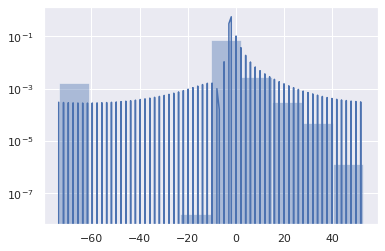

In [41]:
ax = sns.distplot(mpcastack[:,:,0].reshape(5000*5000),bins=10)
ax.set_yscale('log')

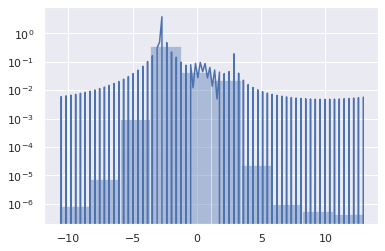

In [42]:
ax = sns.distplot(mpcastack[:,:,1].reshape(5000*5000),bins=10)
ax.set_yscale('log')

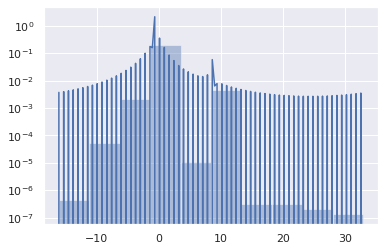

In [43]:
ax = sns.distplot(mpcastack[:,:,2].reshape(5000*5000),bins=10)
ax.set_yscale('log')

#### Task 2
Export PCA as tiff. Rebalance and create usable image.

It looks like we have PCs for low-vegetation brightness, vegetation, and anti-vegetation pro-rockness, perhaps, from looking at the components in the tile-analysis workbook. PC2, index 1, is green; no brainer. I prefer rockness to be red rather than blue, so brightness is left as blue.

Actually probably want to import PIL after all, so I'll add it back to the list of imports now. The key code will be: ```im = Image.merge("RGB", (r, g, b))```  All I have to do is get the channels balanced.

In [13]:
# trying to have this technique scale in a more sophisticated fashion
# first version used whole range with np.min and np.ptp
# in particular, now cutting the outliers off the histogram cf. e.g.
# https://earthobservatory.nasa.gov/blogs/elegantfigures/2013/10/22/how-to-make-a-true-color-landsat-8-image/
def fullscale(channel):
    # scale to 254 rather than 255 to prevent the highest value
    # wrapping around to 0
    newchannel = ma.empty_like(channel,dtype=np.uint8)
    np.putmask(newchannel,channel<=np.quantile(channel,0.05),0)
    np.putmask(newchannel,channel>=np.quantile(channel,0.95),255)
    mask = (channel>np.quantile(channel,0.05)) & (channel<np.quantile(channel,0.95))
    np.putmask(newchannel,mask,np.uint8((channel-np.quantile(channel,0.05))*254/(np.quantile(channel,0.95)
                                                              -np.quantile(channel,0.05))))
    return newchannel

Must leave the file at full extent before transferring georeference information with the gdalcopyproj.py script. After that it should be cropped to 3000 x 2600.

Actually, let's copy the substance of the script into this notebook for clarity. It's not long.

In [60]:
pcafc = ma.concatenate((fullscale(mpcastack[:,:,2]).reshape(5000,5000,1),
                       fullscale(mpcastack[:,:,1]).reshape(5000,5000,1),
                       fullscale(mpcastack[:,:,0]).reshape(5000,5000,1)),axis=2)
pcafc.shape

(5000, 5000, 3)

How have I not found this library before? https://scikit-image.org/docs/stable/user_guide/numpy_images.html I don't even need the library to use the tips on that page.

In [62]:
pcafc[pcafc.mask] = 0
pcafc[0:3,0:3,:]

masked_array(
  data=[[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]]],
  mask=[[[False, False, False],
         [False, False, False],
         [False, False, False]],

        [[False, False, False],
         [False, False, False],
         [False, False, False]],

        [[False, False, False],
         [False, False, False],
         [False, False, False]]],
  fill_value=999999,
  dtype=uint8)

In [63]:
pcafc[1000:1003,1000:1003,:]

masked_array(
  data=[[[83, 211, 106],
         [81, 212, 107],
         [92, 227, 123]],

        [[87, 215, 111],
         [80, 220, 113],
         [81, 227, 120]],

        [[81, 215, 111],
         [85, 228, 120],
         [83, 226, 117]]],
  mask=[[[False, False, False],
         [False, False, False],
         [False, False, False]],

        [[False, False, False],
         [False, False, False],
         [False, False, False]],

        [[False, False, False],
         [False, False, False],
         [False, False, False]]],
  fill_value=999999,
  dtype=uint8)

In [64]:
pcafalsecolor = Image.fromarray(pcafc,mode='RGB')

In [65]:
pcafalsecolor.save('pcafc1.tif',compression='tiff_deflate')

THAT is money. Print that.

In [67]:
# ******************************************************************************
#  $Id$
#
#  Name:     gdalcopyproj.py
#  Project:  GDAL Python Interface
#  Purpose:  Duplicate the geotransform and projection metadata from
#            one raster dataset to another, which can be useful after
#            performing image manipulations with other software that
#            ignores or discards georeferencing metadata.
#  Author:   Schuyler Erle, schuyler@nocat.net
#
# ******************************************************************************
#  Copyright (c) 2005, Frank Warmerdam
#  Copyright (c) 2009-2011, Even Rouault <even dot rouault at spatialys.com>
#
#  Permission is hereby granted, free of charge, to any person obtaining a
#  copy of this software and associated documentation files (the "Software"),
#  to deal in the Software without restriction, including without limitation
#  the rights to use, copy, modify, merge, publish, distribute, sublicense,
#  and/or sell copies of the Software, and to permit persons to whom the
#  Software is furnished to do so, subject to the following conditions:
#
#  The above copyright notice and this permission notice shall be included
#  in all copies or substantial portions of the Software.
#
#  THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS
#  OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
#  FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
#  THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
#  LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
#  FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
#  DEALINGS IN THE SOFTWARE.
# ******************************************************************************

#import sys

# from osgeo import gdal

#if len(sys.argv) < 3:
#    print("Usage: gdalcopyproj.py source_file dest_file")
#    sys.exit(1)

#inp = sys.argv[1]
inp = filestem + '1.tif'
dataset = gdal.Open(inp)
if dataset is None:
    print('Unable to open', inp, 'for reading')
#    sys.exit(1)

projection = dataset.GetProjection()
geotransform = dataset.GetGeoTransform()

if projection is None and geotransform is None:
    print('No projection or geotransform found on file' + input)
#    sys.exit(1)

#output = sys.argv[2]
output = 'pcafc1.tif'
dataset2 = gdal.Open(output, gdal.GA_Update)

if dataset2 is None:
    print('Unable to open', output, 'for writing')
#    sys.exit(1)

if geotransform is not None and geotransform != (0, 1, 0, 0, 0, 1):
    dataset2.SetGeoTransform(geotransform)

if projection is not None and projection != '':
    dataset2.SetProjection(projection)

gcp_count = dataset.GetGCPCount()
if gcp_count != 0:
    dataset2.SetGCPs(dataset.GetGCPs(), dataset.GetGCPProjection())

dataset = None
dataset2 = None

That worked like a charm, and now it's documented. Let's make it a function for the purposes of the rest of this workbook.

In [15]:
def copyproj(output,inp = filestem + '1.tif'):
    """Copies the geospatial setting / projection information
    from the inp file to the output file.
    Based on gdalcopyproj.py by Schuyler Erle.
    Full info in preceding code cell."""
    dataset = gdal.Open(inp)
    if dataset is None:
        print('Unable to open', inp, 'for reading')
        return None
    projection = dataset.GetProjection()
    geotransform = dataset.GetGeoTransform()
    if projection is None and geotransform is None:
        print('No projection or geotransform found on file' + input)
        return None
    dataset2 = gdal.Open(output, gdal.GA_Update)
    if dataset2 is None:
        print('Unable to open', output, 'for writing')
        return None
    if geotransform is not None and geotransform != (0, 1, 0, 0, 0, 1):
        dataset2.SetGeoTransform(geotransform)
    if projection is not None and projection != '':
        dataset2.SetProjection(projection)
    gcp_count = dataset.GetGCPCount()
    if gcp_count != 0:
        dataset2.SetGCPs(dataset.GetGCPs(), dataset.GetGCPProjection())
    dataset = None
    dataset2 = None
    return dataset2

### Interlude: Notes
Copied reference lava flow images for presentation from https://www.usgs.gov/volcanoes/kilauea/geology-history

Kilauea diary entry for Feb 4 2017:
https://volcanoes.usgs.gov/vhp/archive_search.html

HAWAIIAN VOLCANO OBSERVATORY DAILY UPDATE
U.S. Geological Survey
Saturday, February 4, 2017, 8:20 AM HST (Saturday, February 4, 2017, 18:20 UTC)

KILAUEA VOLCANO (VNUM #332010)
19°25'16" N 155°17'13" W, Summit Elevation 4091 ft (1247 m)
Current Volcano Alert Level: WATCH
Current Aviation Color Code: ORANGE

Activity Summary: Kīlauea Volcano continues to erupt at its summit and East Rift Zone. Lava continues to enter the ocean at Kamokuna and surface flows remain active within 2.4 km (1.5 mi) of the vent at Puʻu ʻŌʻō. These lava flows currently pose no threat to nearby communities. Slowing DI deflationary tilt was recorded at the summit and the lava lake surface dropped to 34 m (112 ft) below the floor of Halemaʻumaʻu crater this morning.

Summit Observations: Summit tiltmeters recorded slowing DI deflationary tilt and the lava lake surface dropped to an estimated 34 m (112 ft) below the floor of Halemaʻumaʻu crater this morning. Seismicity rates were at background levels and, as is typical, tremor fluctuated in response to changing lava lake circulation, spattering, and rockfalls. Sulfur dioxide emission rates ranged from about 4,600 to 5,800 metric tons/day over the past week, when measurements were possible during trade wind conditions.

Puʻu ʻŌʻō Observations: Webcam images show persistent glow in long-term sources within the crater. Weak deflationary tilt continued to be recorded at nearby tiltmeters over the past week. Seismicity rates are at background levels. The sulfur dioxide emission rate from all East Rift Zone vents was about 200 metric tons/day when last measured on January 30.

Lava Flow Observations: The episode 61g flow is still active and entering the ocean at Kamokuna; all surface flows are occurring within about 2.4 km (1.5 mi) of the 61g vent near Puʻu ʻŌʻō including scattered surface flows from a small breakout that began on January 22 and surface flows on a secondary branch of the 61g flow. The episode 61g flows pose no threat to nearby communities at this time.

CORRECTION TO YESTERDAY'S UPDATE: HVO scientists observed that a 30 m by 5 m (98 ft by 16 ft) portion of the block seaward of the hot crack REMAINED AFTER THE 12:55 p.m. collapse on Feb. 2. A significantly larger chunk fell into the ocean generating a noticeable, but not unusually large, wave propagating outward from the rockfall location. The dimensions of the collapsed block have not yet been documented.

#### Task 3
Create true-ish color image and a (few) standard false-color image(s). Standard false color image 1 is the real green as blue, real red as green, near IR veg band as red schema our man Robert Simmon described on Medium.

##### 3.1 True Color

In [76]:
tcscstack = ma.concatenate((fullscale(stack[:,:,3].reshape(5000,5000,1)),
                       fullscale(stack[:,:,2].reshape(5000,5000,1)),
                       fullscale(stack[:,:,1].reshape(5000,5000,1))),axis=2)
tcscstack[mstack[:,:,0:3].mask] = 0
tcscimage = Image.fromarray(tcscstack,mode='RGB')
tcscimage.save('tcsc.tif',compression='tiff_deflate')

NameError: name 'copyproj' is not defined

In [78]:
copyproj('tcsc.tif')

Oh, wow. With the new fullscale routine, I get a really bright image that seems to call out a discontinuity in the data extending ESE off the coast of Puna with darker blue water to the south.

Let's try doing this while keeping the original color balance.

In [79]:
tcscstack = fullscale(ma.concatenate((stack[:,:,3].reshape(5000,5000,1),
                       stack[:,:,2].reshape(5000,5000,1),stack[:,:,1].reshape(5000,5000,1)),axis=2))
tcscstack[mstack[:,:,0:3].mask] = 0
tcscimage = Image.fromarray(tcscstack,mode='RGB')
tcscimage.save('tc.tif',compression='tiff_deflate')
copyproj('tc.tif')

That looks no different. Weird.

In [4]:
!gdal_translate -srcwin 0 0 2600 3000 tc.tif tccrop.tif

Input file size is 5000, 5000
0...10...20...30...40...50...60...70...80...90...100 - done.


In [82]:
for i in range(7):
    print('Channel',i+1,': range',np.quantile(stack[:,:,i],(0.05,0.95)))

Channel 1 : range [ 96. 611.]
Channel 2 : range [143. 564.]
Channel 3 : range [ 53. 678.]
Channel 4 : range [  8. 700.]
Channel 5 : range [   0. 2993.]
Channel 6 : range [  15. 1645.]
Channel 7 : range [  12. 1025.]


Seems like there should be some difference, given how large a percentage of the range the difference is between the three visible channels' starting points.

##### Task 3.2 False Color
###### 3.2.1 Vegetation: Bands 5, 4, 3; Indices 4, 3, 2

In [83]:
vscstack = fullscale(ma.concatenate((stack[:,:,4].reshape(5000,5000,1),
                       stack[:,:,3].reshape(5000,5000,1),stack[:,:,2].reshape(5000,5000,1)),axis=2))
vscstack[mstack[:,:,0:3].mask] = 0
vscimage = Image.fromarray(vscstack,mode='RGB')
vscimage.save('vfc.tif',compression='tiff_deflate')
copyproj('vfc.tif')

In [2]:
!gdal_translate -srcwin 0 0 2600 3000 vfc.tif vfccrop.tif

Input file size is 5000, 5000
0...10...20...30...40...50...60...70...80...90...100 - done.


###### 3.2.2 SWIR / Heat: Bands 7, 6, 4; Indices 6, 5, 3

In [16]:
hscstack = fullscale(ma.concatenate((stack[:,:,6].reshape(5000,5000,1),
                       stack[:,:,5].reshape(5000,5000,1),stack[:,:,3].reshape(5000,5000,1)),axis=2))
hscstack[mstack[:,:,0:3].mask] = 0
hscimage = Image.fromarray(hscstack,mode='RGB')
hscimage.save('hfc.tif',compression='tiff_deflate')
copyproj('hfc.tif')

In [3]:
!gdal_translate -srcwin 0 0 2600 3000 hfc.tif hfccrop.tif

Input file size is 5000, 5000
0...10...20...30...40...50...60...70...80...90...100 - done.


###### 3.2.2 Burn / Flood: Bands 6, 5, 4; Indices 5, 4, 3

In [19]:
burnstack = fullscale(ma.concatenate((stack[:,:,5].reshape(5000,5000,1),
                       stack[:,:,4].reshape(5000,5000,1),stack[:,:,3].reshape(5000,5000,1)),axis=2))
burnstack[mstack[:,:,0:3].mask] = 0
burnimage = Image.fromarray(burnstack,mode='RGB')
burnimage.save('bfc.tif',compression='tiff_deflate')
copyproj('bfc.tif')

In [20]:
!gdal_translate -srcwin 0 0 2600 3000 bfc.tif bfccrop.tif

Input file size is 5000, 5000
0...10...20...30...40...50...60...70...80...90...100 - done.


#### Task 4
Create a mosaic of the four images:

| | |
| :----: | :----: |
| True Color | Veg FC |
| Heat FC | PC FC |

In order to do the image merge in Python I need to stack all the data into a single array. I need:
* pfafc array
* slices of stack, bands:
    * 4, 3, 2 = tcscstack array
    * 5, 4, 3 -> vegetation false color
    * 7, 6, 4 -> heat (/ geo) false color

In [88]:
mosaic = np.concatenate((np.concatenate((tcscstack[:3000,:2600,:],hscstack[:3000,:2600,:]),axis=0),
                         np.concatenate((vscstack[:3000,:2600,:],pcafc[:3000,:2600,:]),axis=0)),axis=1)
mosaic.shape

(6000, 5200, 3)

In [89]:
mosimage = Image.fromarray(mosaic,mode='RGB')
mosimage.save('mosaic.tif',compression='tiff_deflate')

Crop all images down to 3000x2600.